## 6.7 GNNの実装

In [1]:
# 依存ライブラリのインストール
# !pip install torch==2.0.0+cpu --index-url \
# https://download.pytorch.org/whl/cpu
# !pip install torch-cluster torch-scatter torch-sparse \
# -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

In [2]:
# 必要なライブラリのインストール
# !pip install torch-geometric==2.3.1 numpy==1.26.4 tqdm

In [3]:
# 必要なライブラリのインポート
from torch_geometric.datasets import Planetoid

# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

Processing...
Done!


In [4]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['y', 'val_mask', 'test_mask', 'x', 'train_mask']
tensor([False,  True,  True,  ...,  True,  True,  True])
tensor([ True, False, False,  ..., False, False, False])


### 6.7.1 GNNによる論文の技術領域の分類

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# GCN モデルの定義
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_node_features, projection_dim)
        self.conv2 = GCNConv(projection_dim, num_classes)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [6]:
# GCN モデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
gcn_model = GCN(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
    num_classes=dataset.num_classes,
).to(device)

# 最適化アルゴリズムの選択
gcn_optimizer = torch.optim.Adam(
    list(gcn_model.parameters()), lr=0.01
)

In [8]:
from tqdm import tqdm

# GCN の学習を行う関数の定義
def train_gcn() -> float:
    gcn_model.train()
    total_loss = 0.0
    gcn_optimizer.zero_grad()
    out = gcn_model(splitted_data)
    loss = F.cross_entropy(
        out[splitted_data.train_mask],
        splitted_data.y[splitted_data.train_mask],
    )
    loss.backward()
    gcn_optimizer.step()
    return loss.item()

# GCN の学習の実行
for epoch in tqdm(range(1, 201)):
    loss = train_gcn()
    print(f"train loss : {loss:.4f}")

 12%|█▏        | 23/200 [00:00<00:01, 110.15it/s]

train loss : 0.0186
train loss : 0.0168
train loss : 0.0168
train loss : 0.0159
train loss : 0.0172
train loss : 0.0166
train loss : 0.0168
train loss : 0.0182
train loss : 0.0178
train loss : 0.0161
train loss : 0.0159
train loss : 0.0155
train loss : 0.0148
train loss : 0.0177
train loss : 0.0150
train loss : 0.0156
train loss : 0.0155
train loss : 0.0133
train loss : 0.0137
train loss : 0.0146
train loss : 0.0148
train loss : 0.0172
train loss : 0.0163


 18%|█▊        | 35/200 [00:00<00:01, 111.53it/s]

train loss : 0.0126
train loss : 0.0125
train loss : 0.0129
train loss : 0.0146
train loss : 0.0162
train loss : 0.0144
train loss : 0.0132
train loss : 0.0149
train loss : 0.0154
train loss : 0.0148
train loss : 0.0115
train loss : 0.0135
train loss : 0.0148
train loss : 0.0146
train loss : 0.0155
train loss : 0.0162
train loss : 0.0123
train loss : 0.0141
train loss : 0.0137
train loss : 0.0132
train loss : 0.0113
train loss : 0.0150
train loss : 0.0108


 30%|██▉       | 59/200 [00:00<00:01, 112.70it/s]

train loss : 0.0140
train loss : 0.0122
train loss : 0.0103
train loss : 0.0140
train loss : 0.0151
train loss : 0.0104
train loss : 0.0121
train loss : 0.0119
train loss : 0.0127
train loss : 0.0111
train loss : 0.0123
train loss : 0.0115
train loss : 0.0106
train loss : 0.0133
train loss : 0.0120
train loss : 0.0114
train loss : 0.0136
train loss : 0.0127
train loss : 0.0118
train loss : 0.0166
train loss : 0.0139
train loss : 0.0097
train loss : 0.0098


 42%|████▏     | 83/200 [00:00<00:01, 111.72it/s]

train loss : 0.0095
train loss : 0.0125
train loss : 0.0119
train loss : 0.0105
train loss : 0.0124
train loss : 0.0133
train loss : 0.0120
train loss : 0.0090
train loss : 0.0107
train loss : 0.0116
train loss : 0.0108
train loss : 0.0101
train loss : 0.0109
train loss : 0.0106
train loss : 0.0107
train loss : 0.0093
train loss : 0.0133
train loss : 0.0113
train loss : 0.0119
train loss : 0.0106
train loss : 0.0100
train loss : 0.0113


 54%|█████▎    | 107/200 [00:00<00:00, 111.66it/s]

train loss : 0.0108
train loss : 0.0110
train loss : 0.0085
train loss : 0.0101
train loss : 0.0098
train loss : 0.0112
train loss : 0.0083
train loss : 0.0081
train loss : 0.0099
train loss : 0.0115
train loss : 0.0111
train loss : 0.0106
train loss : 0.0099
train loss : 0.0092
train loss : 0.0106
train loss : 0.0110
train loss : 0.0097
train loss : 0.0120
train loss : 0.0108
train loss : 0.0089
train loss : 0.0102
train loss : 0.0101
train loss : 0.0092


 66%|██████▌   | 131/200 [00:01<00:00, 109.08it/s]

train loss : 0.0096
train loss : 0.0089
train loss : 0.0115
train loss : 0.0098
train loss : 0.0096
train loss : 0.0083
train loss : 0.0098
train loss : 0.0079
train loss : 0.0103
train loss : 0.0087
train loss : 0.0110
train loss : 0.0111
train loss : 0.0092
train loss : 0.0110
train loss : 0.0092
train loss : 0.0080
train loss : 0.0091
train loss : 0.0109
train loss : 0.0101
train loss : 0.0098
train loss : 0.0088
train loss : 0.0085


 76%|███████▋  | 153/200 [00:01<00:00, 108.71it/s]

train loss : 0.0068
train loss : 0.0078
train loss : 0.0089
train loss : 0.0093
train loss : 0.0078
train loss : 0.0090
train loss : 0.0130
train loss : 0.0100
train loss : 0.0089
train loss : 0.0085
train loss : 0.0082
train loss : 0.0075
train loss : 0.0098
train loss : 0.0086
train loss : 0.0085
train loss : 0.0085
train loss : 0.0094
train loss : 0.0079
train loss : 0.0085
train loss : 0.0079
train loss : 0.0090
train loss : 0.0080
train loss : 0.0078


 88%|████████▊ | 175/200 [00:01<00:00, 107.01it/s]

train loss : 0.0089
train loss : 0.0083
train loss : 0.0092
train loss : 0.0098
train loss : 0.0089
train loss : 0.0085
train loss : 0.0075
train loss : 0.0085
train loss : 0.0109
train loss : 0.0086
train loss : 0.0097
train loss : 0.0085
train loss : 0.0077
train loss : 0.0085
train loss : 0.0061
train loss : 0.0086
train loss : 0.0076
train loss : 0.0080
train loss : 0.0066
train loss : 0.0074
train loss : 0.0093
train loss : 0.0076


100%|██████████| 200/200 [00:01<00:00, 110.03it/s]

train loss : 0.0062
train loss : 0.0068
train loss : 0.0074
train loss : 0.0090
train loss : 0.0078
train loss : 0.0059
train loss : 0.0065
train loss : 0.0081
train loss : 0.0089
train loss : 0.0084
train loss : 0.0067
train loss : 0.0074
train loss : 0.0070
train loss : 0.0069
train loss : 0.0057
train loss : 0.0086
train loss : 0.0076
train loss : 0.0084
train loss : 0.0073


In [9]:
from sklearn.metrics import classification_report

y_true = splitted_data.y[splitted_data.test_mask].numpy()

# 評価データに対する推論
with torch.no_grad():
    gcn_model.eval()
    out = gcn_model(splitted_data)
y_pred = out.argmax(dim=1)[splitted_data.test_mask]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       153
           1       0.89      0.77      0.83        88
           2       0.94      0.96      0.95       161
           3       0.92      0.88      0.90       325
           4       0.82      0.93      0.87       166
           5       0.81      0.88      0.84       122
           6       0.87      0.76      0.81        68

    accuracy                           0.87      1083
   macro avg       0.86      0.85      0.85      1083
weighted avg       0.87      0.87      0.86      1083



### 6.7.2 フィルタの差し替え

In [10]:
from torch_geometric.nn import SAGEConv

# GraphSAGE モデルの定義
class GraphSAGE(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.conv1 = SAGEConv(num_node_features, projection_dim)
        self.conv2 = SAGEConv(projection_dim, num_classes)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [11]:
# GraphSAGE モデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
sage_model = GraphSAGE(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
    num_classes=dataset.num_classes,
).to(device)
sage_optimizer = torch.optim.Adam(
    list(sage_model.parameters()), lr=0.01
)

In [12]:
# GraphSAGEモデルの学習を行う関数の定義
def train_sage() -> float:
    sage_model.train()
    total_loss = 0
    sage_optimizer.zero_grad()
    out = sage_model(splitted_data)
    loss = F.cross_entropy(
        out[splitted_data.train_mask],
        splitted_data.y[splitted_data.train_mask],
    )
    loss.backward()
    sage_optimizer.step()
    return loss.item()


# GraphSAGEモデルの学習の実行
for epoch in tqdm(range(1, 201)):
    loss = train_sage()
    print(f"train loss : {loss:.4f}")

  2%|▎         | 5/200 [00:00<00:04, 43.04it/s]

train loss : 1.9218
train loss : 1.6690
train loss : 1.3818
train loss : 1.0896
train loss : 0.8061
train loss : 0.6092
train loss : 0.4571
train loss : 0.3613
train loss : 0.2999


  8%|▊         | 15/200 [00:00<00:04, 42.99it/s]

train loss : 0.2547
train loss : 0.2191
train loss : 0.1905
train loss : 0.1783
train loss : 0.1630
train loss : 0.1452
train loss : 0.1081
train loss : 0.1110
train loss : 0.0853


 12%|█▎        | 25/200 [00:00<00:04, 43.51it/s]

train loss : 0.0838
train loss : 0.0690
train loss : 0.0680
train loss : 0.0563
train loss : 0.0440
train loss : 0.0394
train loss : 0.0338
train loss : 0.0318
train loss : 0.0253


 18%|█▊        | 35/200 [00:00<00:03, 43.56it/s]

train loss : 0.0190
train loss : 0.0236
train loss : 0.0201
train loss : 0.0187
train loss : 0.0175
train loss : 0.0136
train loss : 0.0154
train loss : 0.0154
train loss : 0.0109


 22%|██▎       | 45/200 [00:01<00:03, 43.16it/s]

train loss : 0.0132
train loss : 0.0084
train loss : 0.0122
train loss : 0.0102
train loss : 0.0113
train loss : 0.0080
train loss : 0.0062
train loss : 0.0060
train loss : 0.0075


 25%|██▌       | 50/200 [00:01<00:03, 42.98it/s]

train loss : 0.0093
train loss : 0.0053
train loss : 0.0052
train loss : 0.0058
train loss : 0.0057
train loss : 0.0061
train loss : 0.0059
train loss : 0.0048
train loss : 0.0066


 30%|███       | 60/200 [00:01<00:03, 43.39it/s]

train loss : 0.0045
train loss : 0.0041
train loss : 0.0051
train loss : 0.0039
train loss : 0.0034
train loss : 0.0042
train loss : 0.0048
train loss : 0.0041
train loss : 0.0044


 35%|███▌      | 70/200 [00:01<00:03, 42.60it/s]

train loss : 0.0031
train loss : 0.0037
train loss : 0.0029
train loss : 0.0027
train loss : 0.0027
train loss : 0.0038
train loss : 0.0034
train loss : 0.0030
train loss : 0.0028


 40%|████      | 80/200 [00:01<00:02, 43.10it/s]

train loss : 0.0021
train loss : 0.0038
train loss : 0.0020
train loss : 0.0035
train loss : 0.0022
train loss : 0.0030
train loss : 0.0028
train loss : 0.0020
train loss : 0.0019


 45%|████▌     | 90/200 [00:02<00:02, 42.71it/s]

train loss : 0.0027
train loss : 0.0033
train loss : 0.0020
train loss : 0.0028
train loss : 0.0019
train loss : 0.0022
train loss : 0.0025
train loss : 0.0017
train loss : 0.0025


 48%|████▊     | 95/200 [00:02<00:02, 42.88it/s]

train loss : 0.0026
train loss : 0.0016
train loss : 0.0026
train loss : 0.0012
train loss : 0.0021
train loss : 0.0021
train loss : 0.0025
train loss : 0.0020
train loss : 0.0026


 52%|█████▎    | 105/200 [00:02<00:02, 43.20it/s]

train loss : 0.0017
train loss : 0.0015
train loss : 0.0023
train loss : 0.0028
train loss : 0.0016
train loss : 0.0022
train loss : 0.0025
train loss : 0.0013
train loss : 0.0017


 57%|█████▊    | 115/200 [00:02<00:02, 42.07it/s]

train loss : 0.0031
train loss : 0.0013
train loss : 0.0015
train loss : 0.0018
train loss : 0.0015
train loss : 0.0022
train loss : 0.0025
train loss : 0.0011
train loss : 0.0021


 62%|██████▎   | 125/200 [00:02<00:01, 42.22it/s]

train loss : 0.0022
train loss : 0.0016
train loss : 0.0013
train loss : 0.0024
train loss : 0.0026
train loss : 0.0015
train loss : 0.0014
train loss : 0.0023
train loss : 0.0014


 68%|██████▊   | 135/200 [00:03<00:01, 42.49it/s]

train loss : 0.0022
train loss : 0.0015
train loss : 0.0013
train loss : 0.0009
train loss : 0.0013
train loss : 0.0012
train loss : 0.0013
train loss : 0.0020
train loss : 0.0015


 70%|███████   | 140/200 [00:03<00:01, 42.53it/s]

train loss : 0.0013
train loss : 0.0012
train loss : 0.0013
train loss : 0.0018
train loss : 0.0013
train loss : 0.0019
train loss : 0.0014
train loss : 0.0012
train loss : 0.0011


 75%|███████▌  | 150/200 [00:03<00:01, 43.43it/s]

train loss : 0.0019
train loss : 0.0021
train loss : 0.0022
train loss : 0.0014
train loss : 0.0013
train loss : 0.0014
train loss : 0.0007
train loss : 0.0012
train loss : 0.0012


 80%|████████  | 160/200 [00:03<00:00, 43.52it/s]

train loss : 0.0009
train loss : 0.0009
train loss : 0.0011
train loss : 0.0009
train loss : 0.0009
train loss : 0.0014
train loss : 0.0009
train loss : 0.0014
train loss : 0.0013


 85%|████████▌ | 170/200 [00:03<00:00, 42.19it/s]

train loss : 0.0014
train loss : 0.0014
train loss : 0.0010
train loss : 0.0017
train loss : 0.0006
train loss : 0.0007
train loss : 0.0017
train loss : 0.0015
train loss : 0.0010


 90%|█████████ | 180/200 [00:04<00:00, 42.11it/s]

train loss : 0.0007
train loss : 0.0012
train loss : 0.0006
train loss : 0.0008
train loss : 0.0025
train loss : 0.0011
train loss : 0.0008
train loss : 0.0008
train loss : 0.0008


 92%|█████████▎| 185/200 [00:04<00:00, 42.16it/s]

train loss : 0.0008
train loss : 0.0023
train loss : 0.0008
train loss : 0.0013
train loss : 0.0010
train loss : 0.0012
train loss : 0.0011
train loss : 0.0010
train loss : 0.0014


 98%|█████████▊| 195/200 [00:04<00:00, 41.76it/s]

train loss : 0.0006
train loss : 0.0008
train loss : 0.0010
train loss : 0.0007
train loss : 0.0007
train loss : 0.0018
train loss : 0.0021
train loss : 0.0010
train loss : 0.0008


100%|██████████| 200/200 [00:04<00:00, 42.72it/s]

train loss : 0.0011
train loss : 0.0007


In [13]:
from sklearn.metrics import classification_report
from sklearn.utils.validation import column_or_1d

y_true = column_or_1d(splitted_data.y[splitted_data.test_mask].numpy())

# 評価データに対する推論
with torch.no_grad():
    sage_model.eval()
    out = sage_model(splitted_data)
    y_pred = out.argmax(dim=1)[splitted_data.test_mask]

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       153
           1       0.96      0.84      0.90        88
           2       0.93      0.95      0.94       161
           3       0.92      0.90      0.91       325
           4       0.85      0.92      0.88       166
           5       0.87      0.86      0.86       122
           6       0.81      0.85      0.83        68

    accuracy                           0.88      1083
   macro avg       0.88      0.87      0.87      1083
weighted avg       0.88      0.88      0.88      1083



### 6.8.3 GNNによる論文の引用関係の予測

In [14]:
from torch_geometric.transforms import RandomLinkSplit

# エッジを学習データとテストデータに分割
link_splitter = RandomLinkSplit(
    num_val=0.0,
    num_test=0.4,
    is_undirected=True,
)
train_data, _, test_data = link_splitter(dataset._data)
print(train_data.edge_label_index.shape)
print(test_data.edge_label_index.shape)

torch.Size([2, 6334])
torch.Size([2, 4222])


In [15]:
# GCNによる特徴変換の定義
class GCNLayer(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
    ) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_node_features, projection_dim)
        self.conv2 = GCNConv(projection_dim, projection_dim)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)


# リンク予測モデルの定義
class LinkPredModel(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
    ) -> None:
        super().__init__()
        self.gcn_layer = GCNLayer(num_node_features, projection_dim)

    def forward(self, data: Data, edge_label_index: torch.Tensor) -> None:
        x = self.gcn_layer(data)
        x_src = x[edge_label_index[0]]
        x_dst = x[edge_label_index[1]]
        # 内積をシグモイド関数に入力して、0〜1の値に変換
        return F.sigmoid((x_src * x_dst).sum(-1))

In [19]:
# リンク予測モデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
link_pred_model = LinkPredModel(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
).to(device)

# 最適化アルゴリズムの選択
link_pred_optimizer = torch.optim.Adam(list(link_pred_model.parameters()), lr=0.01)

In [20]:
from torch_geometric.utils import negative_sampling


# リンク予測モデルを学習する関数の定義
def train_link_pred_model() -> float:
    link_pred_model.train()
    link_pred_optimizer.zero_grad()

    total_loss = 0
    link_pred_optimizer.zero_grad()

    # Negative Samplingによる負例の獲得
    negative_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method="sparse",
    )

    # 学習対象のエッジのインデックス
    edge_label_index = torch.cat(
        [train_data.edge_label_index, negative_edge_index],
        dim=-1,
    )

    # 学習対象のエッジのラベル
    # 1は実在するリンク、0はランダムに選ばれたノード間のリンク
    edge_label = torch.cat(
        [
            train_data.edge_label,
            train_data.edge_label.new_zeros(negative_edge_index.size(1)),
        ],
        dim=0,
    )
    out = link_pred_model(train_data, edge_label_index)
    loss = F.binary_cross_entropy(out, edge_label)
    loss.backward()
    link_pred_optimizer.step()
    total_loss += loss.item()
    return total_loss


# リンク予測モデルの学習の実行
for epoch in tqdm(range(1, 31)):
    loss = train_link_pred_model()
    print(f"train loss : {loss:.4f}")

 33%|███▎      | 10/30 [00:00<00:00, 46.37it/s]

train loss : 0.7032
train loss : 0.8219
train loss : 0.7053
train loss : 0.7021
train loss : 0.6952
train loss : 0.6937
train loss : 0.6925
train loss : 0.6898
train loss : 0.6854
train loss : 0.6796


 53%|█████▎    | 16/30 [00:00<00:00, 48.85it/s]

train loss : 0.6690
train loss : 0.6593
train loss : 0.6530
train loss : 0.6454
train loss : 0.6363
train loss : 0.6346
train loss : 0.6329
train loss : 0.6308
train loss : 0.6276
train loss : 0.6200
train loss : 0.6266


100%|██████████| 30/30 [00:00<00:00, 49.45it/s]

train loss : 0.6247
train loss : 0.6232
train loss : 0.6122
train loss : 0.6147
train loss : 0.6088
train loss : 0.6018
train loss : 0.6051
train loss : 0.6009
train loss : 0.5986


In [21]:
from sklearn.metrics import roc_auc_score

# 評価データに対する推論
with torch.no_grad():
    link_pred_model.eval()
    out = link_pred_model(test_data, test_data.edge_label_index)
    y_true = test_data.edge_label.numpy()
    y_pred = out.numpy()

# AUCの計算
print(f"AUC : {roc_auc_score(y_true, y_pred):.4f}")

AUC : 0.8338


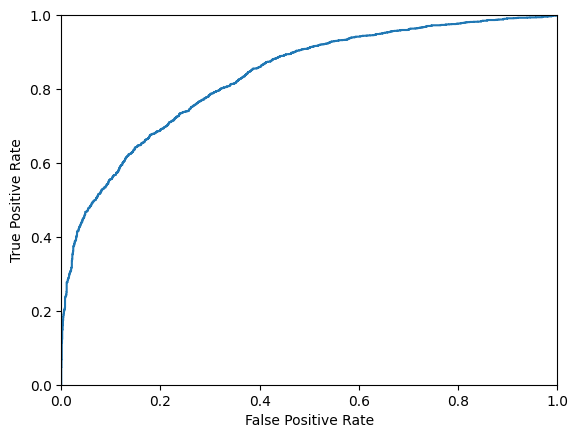

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC曲線の描画
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()